In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [40]:
np.random.seed(42)

In [41]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

/opt/homebrew/Caskroom/miniconda/base/envs/code/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [42]:
mnist.data.shape

(70000, 784)

In [43]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [44]:
X/=255.0

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

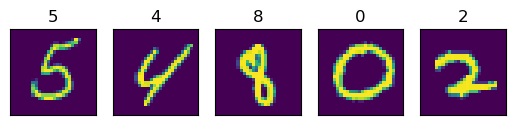

In [47]:
plot_example(X_train, y_train)

In [67]:
import torch
from torch import nn
import torch.nn.functional as F

torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [76]:
input_dim = X.shape[1]
hidden_dim = 20
output_dim = 10

In [77]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        hid = self.hidden_layer(X)
        hid_relu = self.nonlin(hid)
        hid_relu_drop = self.dropout(hid_relu)
        out = self.output_layer(hid_relu_drop)
        probs = F.softmax(out, dim=-1)
        return probs, out, hid_relu, hid

In [78]:
from skorch import NeuralNetClassifier

In [79]:
class ClassifierNet(NeuralNetClassifier):
    def get_loss(self, y_pred, y_true, *args, **kwargs):
        probs, output, hid_relu, hid = y_pred
        return super().get_loss(probs, y_true, *args, **kwargs)

In [80]:
net = ClassifierNet(
    ClassifierModule,
    max_epochs=50,
    lr=0.1)

In [81]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2053       0.8751        0.5236  0.2986
      2        0.8046       0.8956        0.4176  0.2731
      3        0.7305       0.8998        0.3842  0.2810
      4        0.7069       0.9024        0.3651  0.3173
      5        0.6890       0.9059        0.3490  0.2811
      6        0.6696       0.9094        0.3299  0.2889
      7        0.6669       0.9103        0.3258  0.2861
      8        0.6573       0.9130        0.3156  0.2743
      9        0.6452       0.9112        0.3126  0.2721
     10        0.6439       0.9134        0.3075  0.2715
     11        0.6310       0.9156        0.3037  0.2766
     12        0.6304       0.9162        0.2979  0.2766
     13        0.6189       0.9155        0.2935  0.2762
     14        0.6199       0.9169        0.2918  0.2727
     15        0.6174       0.9206        0.2869  0.2783
     16        0.6121       0.9

<class '__main__.ClassifierNet'>[initialized](
  module_=ClassifierModule(
    (hidden_layer): Linear(in_features=784, out_features=20, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (output_layer): Linear(in_features=20, out_features=10, bias=True)
  ),
)

In [82]:
# Making prediction for first 5 data points of X
y_pred = net.predict(X_test[:5])
y_pred

array([8, 4, 5, 7, 7])

In [83]:
y_out = net.forward(X_test[:5])
y_pred = y_out[1].numpy().argmax(1)
y_pred

array([8, 4, 5, 7, 7])

In [ ]:
# Checking probarbility of each class for first 5 data points of X
y_proba = net.predict_proba(X[:5])
y_proba

In [91]:
y_pred = net.predict(X_test)
sum(y_test == y_pred)/len(y_test)

0.9313571428571429

In [ ]:
dict(net.get_all_learnable_params())['hidden_layer.weight'].detach().numpy()

In [85]:
model_data = {}

for param in net.get_all_learnable_params():
    model_data[param[0]] = param[1].detach().numpy().flatten()
    
model_data

{'hidden_layer.weight': array([-0.02448081,  0.03203928, -0.00945938, ..., -0.00975679,
         0.00860115,  0.01197949], dtype=float32),
 'hidden_layer.bias': array([ 0.11924172, -0.25702068, -0.3657261 , -0.5371215 , -0.49257886,
        -0.6122999 , -0.6142976 ,  1.1997513 ,  0.1511106 ,  0.05111085,
        -0.19184524,  0.24291962, -1.0575203 , -0.37877414,  0.10841223,
         0.21820208,  0.9989543 ,  0.53919125,  0.37816167,  0.16991903],
       dtype=float32),
 'output_layer.weight': array([-0.41038993, -0.8864554 , -0.95346326, -1.1938698 , -0.96469045,
         0.65605104, -1.4380188 ,  0.73516756,  0.01890494,  0.6669712 ,
         0.5050056 , -0.87012583,  0.7344386 , -0.7996258 ,  0.61766964,
         0.63174284,  0.81355214, -1.137027  , -0.32367334, -1.0747054 ,
        -1.2947724 ,  0.6419555 , -0.7560812 , -0.64076567,  0.8293333 ,
        -0.9234198 ,  0.7114406 , -1.2430638 , -0.5064362 , -0.8474891 ,
        -0.32151207, -0.999014  , -1.173742  ,  0.73906523, -1.

In [93]:
idx = 5

In [94]:
(X_test[idx]*(10**6)).round().astype(int)

array([      0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,  113725,  772549, 1000000,
        545098,     

In [95]:
y = net.forward(X_test[idx])
y

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x128 and 784x20)

In [107]:
x = X_test[:5]
y = net.forward(x)
y

(tensor([[3.2616e-13, 2.8814e-12, 5.8566e-04, 1.6586e-05, 6.3747e-14, 9.8997e-04,
          3.3239e-12, 3.1290e-14, 9.9841e-01, 3.0843e-10],
         [4.5642e-08, 5.3214e-09, 2.4170e-05, 6.7821e-06, 9.7625e-01, 2.0017e-03,
          2.2955e-07, 5.5003e-04, 9.8854e-04, 2.0178e-02],
         [2.1775e-02, 2.6817e-04, 5.7213e-03, 1.7085e-03, 8.0426e-03, 4.4847e-01,
          1.6200e-01, 1.6889e-05, 3.5016e-01, 1.8330e-03],
         [1.2655e-03, 9.7786e-06, 6.2008e-02, 1.4975e-01, 3.2650e-09, 8.7413e-04,
          6.0122e-09, 7.8340e-01, 2.1671e-03, 5.2160e-04],
         [8.6026e-04, 9.0423e-06, 1.1639e-03, 1.1740e-03, 3.1760e-06, 4.8511e-03,
          6.9705e-08, 9.7680e-01, 2.9877e-03, 1.2154e-02]]),
 tensor([[-10.0919,  -7.9132,  11.2167,   7.6526, -11.7243,  11.7417,  -7.7704,
          -12.4360,  18.6579,  -3.2400],
         [ -7.6701,  -9.8192,  -1.3981,  -2.6689,   9.2083,   3.0186,  -6.0548,
            1.7268,   2.3130,   5.3291],
         [  0.8233,  -3.5736,  -0.5133,  -1.7219,  

In [108]:
net.forward(x)

(tensor([[3.2616e-13, 2.8814e-12, 5.8566e-04, 1.6586e-05, 6.3747e-14, 9.8997e-04,
          3.3239e-12, 3.1290e-14, 9.9841e-01, 3.0843e-10],
         [4.5642e-08, 5.3214e-09, 2.4170e-05, 6.7821e-06, 9.7625e-01, 2.0017e-03,
          2.2955e-07, 5.5003e-04, 9.8854e-04, 2.0178e-02],
         [2.1775e-02, 2.6817e-04, 5.7213e-03, 1.7085e-03, 8.0426e-03, 4.4847e-01,
          1.6200e-01, 1.6889e-05, 3.5016e-01, 1.8330e-03],
         [1.2655e-03, 9.7786e-06, 6.2008e-02, 1.4975e-01, 3.2650e-09, 8.7413e-04,
          6.0122e-09, 7.8340e-01, 2.1671e-03, 5.2160e-04],
         [8.6026e-04, 9.0423e-06, 1.1639e-03, 1.1740e-03, 3.1760e-06, 4.8511e-03,
          6.9705e-08, 9.7680e-01, 2.9877e-03, 1.2154e-02]]),
 tensor([[-10.0919,  -7.9132,  11.2167,   7.6526, -11.7243,  11.7417,  -7.7704,
          -12.4360,  18.6579,  -3.2400],
         [ -7.6701,  -9.8192,  -1.3981,  -2.6689,   9.2083,   3.0186,  -6.0548,
            1.7268,   2.3130,   5.3291],
         [  0.8233,  -3.5736,  -0.5133,  -1.7219,  

In [100]:
in_json = {
    "input": (x[0]*(10**6)).round().astype(int).tolist(),
    "hid_weights": (model_data['hidden_layer.weight']*(10**6)).round().astype(int).tolist(),
    "hid_bias": (model_data['hidden_layer.bias']*(10**12)).round().astype(int).tolist(),
    "out_weights":(model_data['output_layer.weight']*(10**6)).round().astype(int).tolist(),
    "out_bias": (model_data['output_layer.bias']*(10**18)).round().astype(int).tolist() # can also change to zero because we are doing argmax instead of softmax
}

In [101]:
in_json

{'input': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  376471,
  474510,
  474510,
  474510,
  474510,
  745098,
  474510,
  745098,
  745098,
  635294,
  854902,
  474510,
  474510,
  423529,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  180392,
  419608,
  858824,
  976471,
  9882

In [103]:
(y[1][0].numpy()*(10**18))

array([-1.00918684e+19, -7.91323185e+18,  1.12167397e+19,  7.65257406e+18,
       -1.17243376e+19,  1.17416821e+19, -7.77035761e+18, -1.24359570e+19,
        1.86579208e+19, -3.24000025e+18])

In [104]:
out_json = {
    "scale": 10**-18,
    "out": (y[1][0].detach().numpy()*(10**18)).round().astype(int).tolist(),
    "label": int(y[1].argmax())
}
out_json

/var/folders/vx/mp1crwqx5yg2cjnczjljpjmh0000gn/T/ipykernel_47473/866016.py:3: RuntimeWarning: invalid value encountered in cast
  "out": (y[1][0].detach().numpy()*(10**18)).round().astype(int).tolist(),


{'scale': 1e-18,
 'out': [-9223372036854775808,
  -7913231849670410240,
  9223372036854775807,
  7652574062347412480,
  -9223372036854775808,
  9223372036854775807,
  -7770357608795165696,
  -9223372036854775808,
  9223372036854775807,
  -3240000247955322368],
 'label': 8}

In [105]:
import json
with open("mnist_fc_input.json", "w") as f:
    json.dump(in_json, f)
with open("mnist_fc_output.json", "w") as f:
    json.dump(out_json, f)

In [106]:
with open('mnist_fc_test.txt', 'w') as f:
    for key in in_json:
        f.write(key + " = [")
        for idx, value in enumerate(in_json[key]):
            if(idx!=0):
                f.write(', ')
            f.write('"' + str(value) + '"')
        f.write(']\n')


In [ ]:
(y[2].numpy()*10**12).round().astype(int).tolist()

In [111]:
(X_test*(10**6)).round().astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [112]:
predictions = net.predict(X_test)

In [115]:
n_samples = 100
model_name = 'mnist_fc'

with open(f"tests_{model_name}.txt", 'w') as f:
    for i in range(len(X_test[:n_samples])):
        f.write('#[test]\n')
        f.write(f"fn test_{model_name}_{i+1:03d}" + "() {\n")
        f.write("  let sample = [")
        for idx, value in enumerate(X_test[i]):
            if(idx!=0):
                f.write(', ')
            f.write(str((value*(10**6)).round().astype(int)))
        f.write('];\n')
        f.write(f"  assert({model_name}(sample) == " + str(predictions[i]) + ");\n")
        f.write('}\n\n')